<a href="https://colab.research.google.com/github/ax3cubed/harmful-object-recognition/blob/main/object_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai --upgrade
!pip install pydicom
!pip install rfpimp

     |████████████████████████████████| 189 kB 4.1 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 2.0 MB 4.3 MB/s 
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10667 sha256=de510ad02937d920e52a1a2006dfdaae3862b3b22f3146f2329b5bf746664fee
  Stored in directory: /root/.cache/pip/wheels/ad/48/d9/21fc62fbeff405425b0d5dd8b0354576cdb62ac97f6b11d1ef
Successfully built rfpimp


In [2]:
#@title Set up Directory { run: "auto"}
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy
import warnings
import os
import PIL
import fastai
from fastai.tabular.all import *
from fastai.basics import *
from rfpimp import *
from fastai.vision import *
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as T
from tqdm import tqdm
import cv2
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
print(fastai.__version__)
from google.colab import drive
drive.mount('/content/gdrive')
working_directory = 'My Drive/ObjectRecognition' #@param {type:"string"}
weapon_dataset = 'My Drive/WeaponDataset' #@param {type:"string"}
wd="/content/gdrive/"+working_directory
weaponDataset ="/content/gdrive/"+weapon_dataset
os.chdir(wd)

dirpath = os.getcwd()
print("current directory is : " + dirpath)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


2.5.3
Mounted at /content/gdrive
current directory is : /content/gdrive/My Drive/ObjectRecognition


In [3]:
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=100,),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.3),
    batch_tfms=aug_transforms(mult=2)
)

Different blocks can be used, in this case, we used ImageBlock as the x and CategoryBlock as the label. It is also possible to use other blocks such as MultiCategoryBlock, MaskBlock, PointBlock, BBoxBlock, BBoxLblBlock for different applications. I used get_image_files function in fastai to get the path of the images as the x and used parent_label method to find the folder names as the label. There are some built-in functions in fastai, you can also write your own function to do this. Then I used RandomSplitter to split the training and validation dataset. Then used RandomResizedCrop to resize the image to 224 and aug_transforms() for data augmentation.

In [4]:
dls = fields.dataloaders(weaponDataset)

Lets Display the classes

In [5]:
dls.vocab

['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'billete', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'knife', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'monedero', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pistol', 'pizza', 'platypus', 'pyramid', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpi

also lets display some of the images in these classes

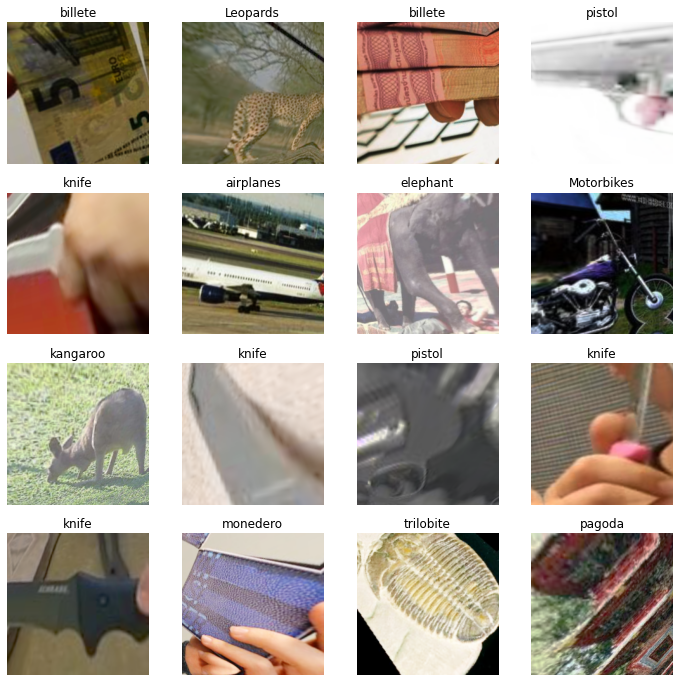

In [6]:
dls.train.show_batch(max_n=16, nrows=4)

In [7]:
def train_cnn(arch, epochs, learning_rate):
    #train
     #define learner
    learn = cnn_learner(dls, arch, metrics=[accuracy, RocAuc( average='weighted'), F1Score(average='weighted'), Precision(average='weighted'), Recall(average='weighted')])
    learn.fit_one_cycle(epochs,learning_rate)
    learn.unfreeze()
    learn.fine_tune(epochs)
    learn.unfreeze()
    
    %time learn.validate()
    return learn

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,precision_score,recall_score,time
0,1.337538,0.721603,0.794721,0.994147,0.784742,0.810761,0.794721,1:35:36


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,precision_score,recall_score,time
0,0.982919,0.548541,0.843242,0.995992,0.837467,0.851201,0.843242,05:06


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,precision_score,recall_score,time
0,0.818734,0.422134,0.872567,0.997446,0.867878,0.881133,0.872567,06:37


CPU times: user 18.1 s, sys: 526 ms, total: 18.6 s
Wall time: 32.3 s


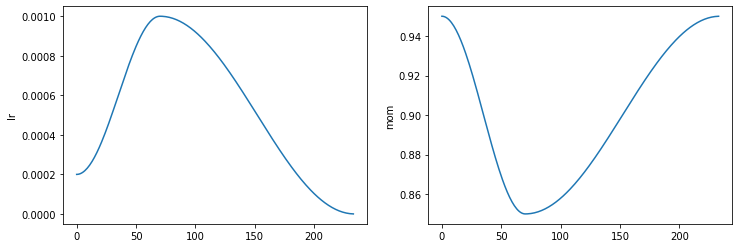

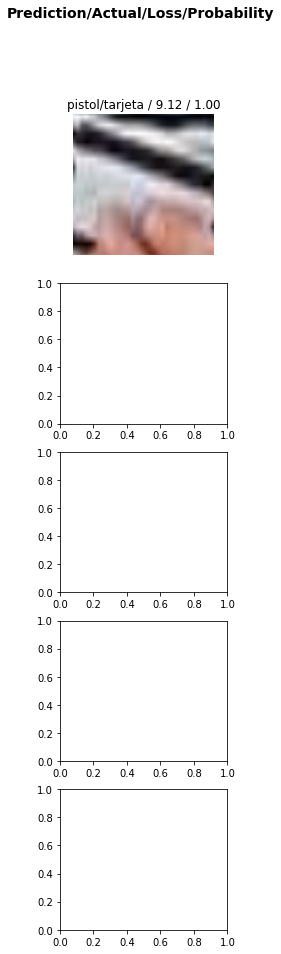

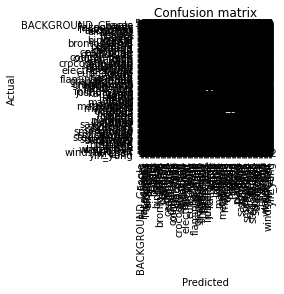

In [8]:
resnet_learner = train_cnn(models.resnet50, 1, 2.0e-2)
resnet_learner.recorder.plot_sched()
resnet_learner.export(fname="resnet_model.pkl")

In [15]:
def interpretation(arch):
  interp = ClassificationInterpretation.from_learner(arch);
  interp.plot_top_losses(5, nrows=5)
  return interp

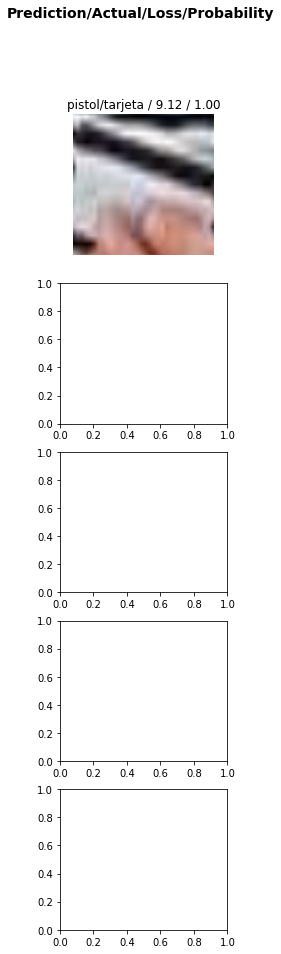

In [17]:
interp =interpretation(resnet_learner)

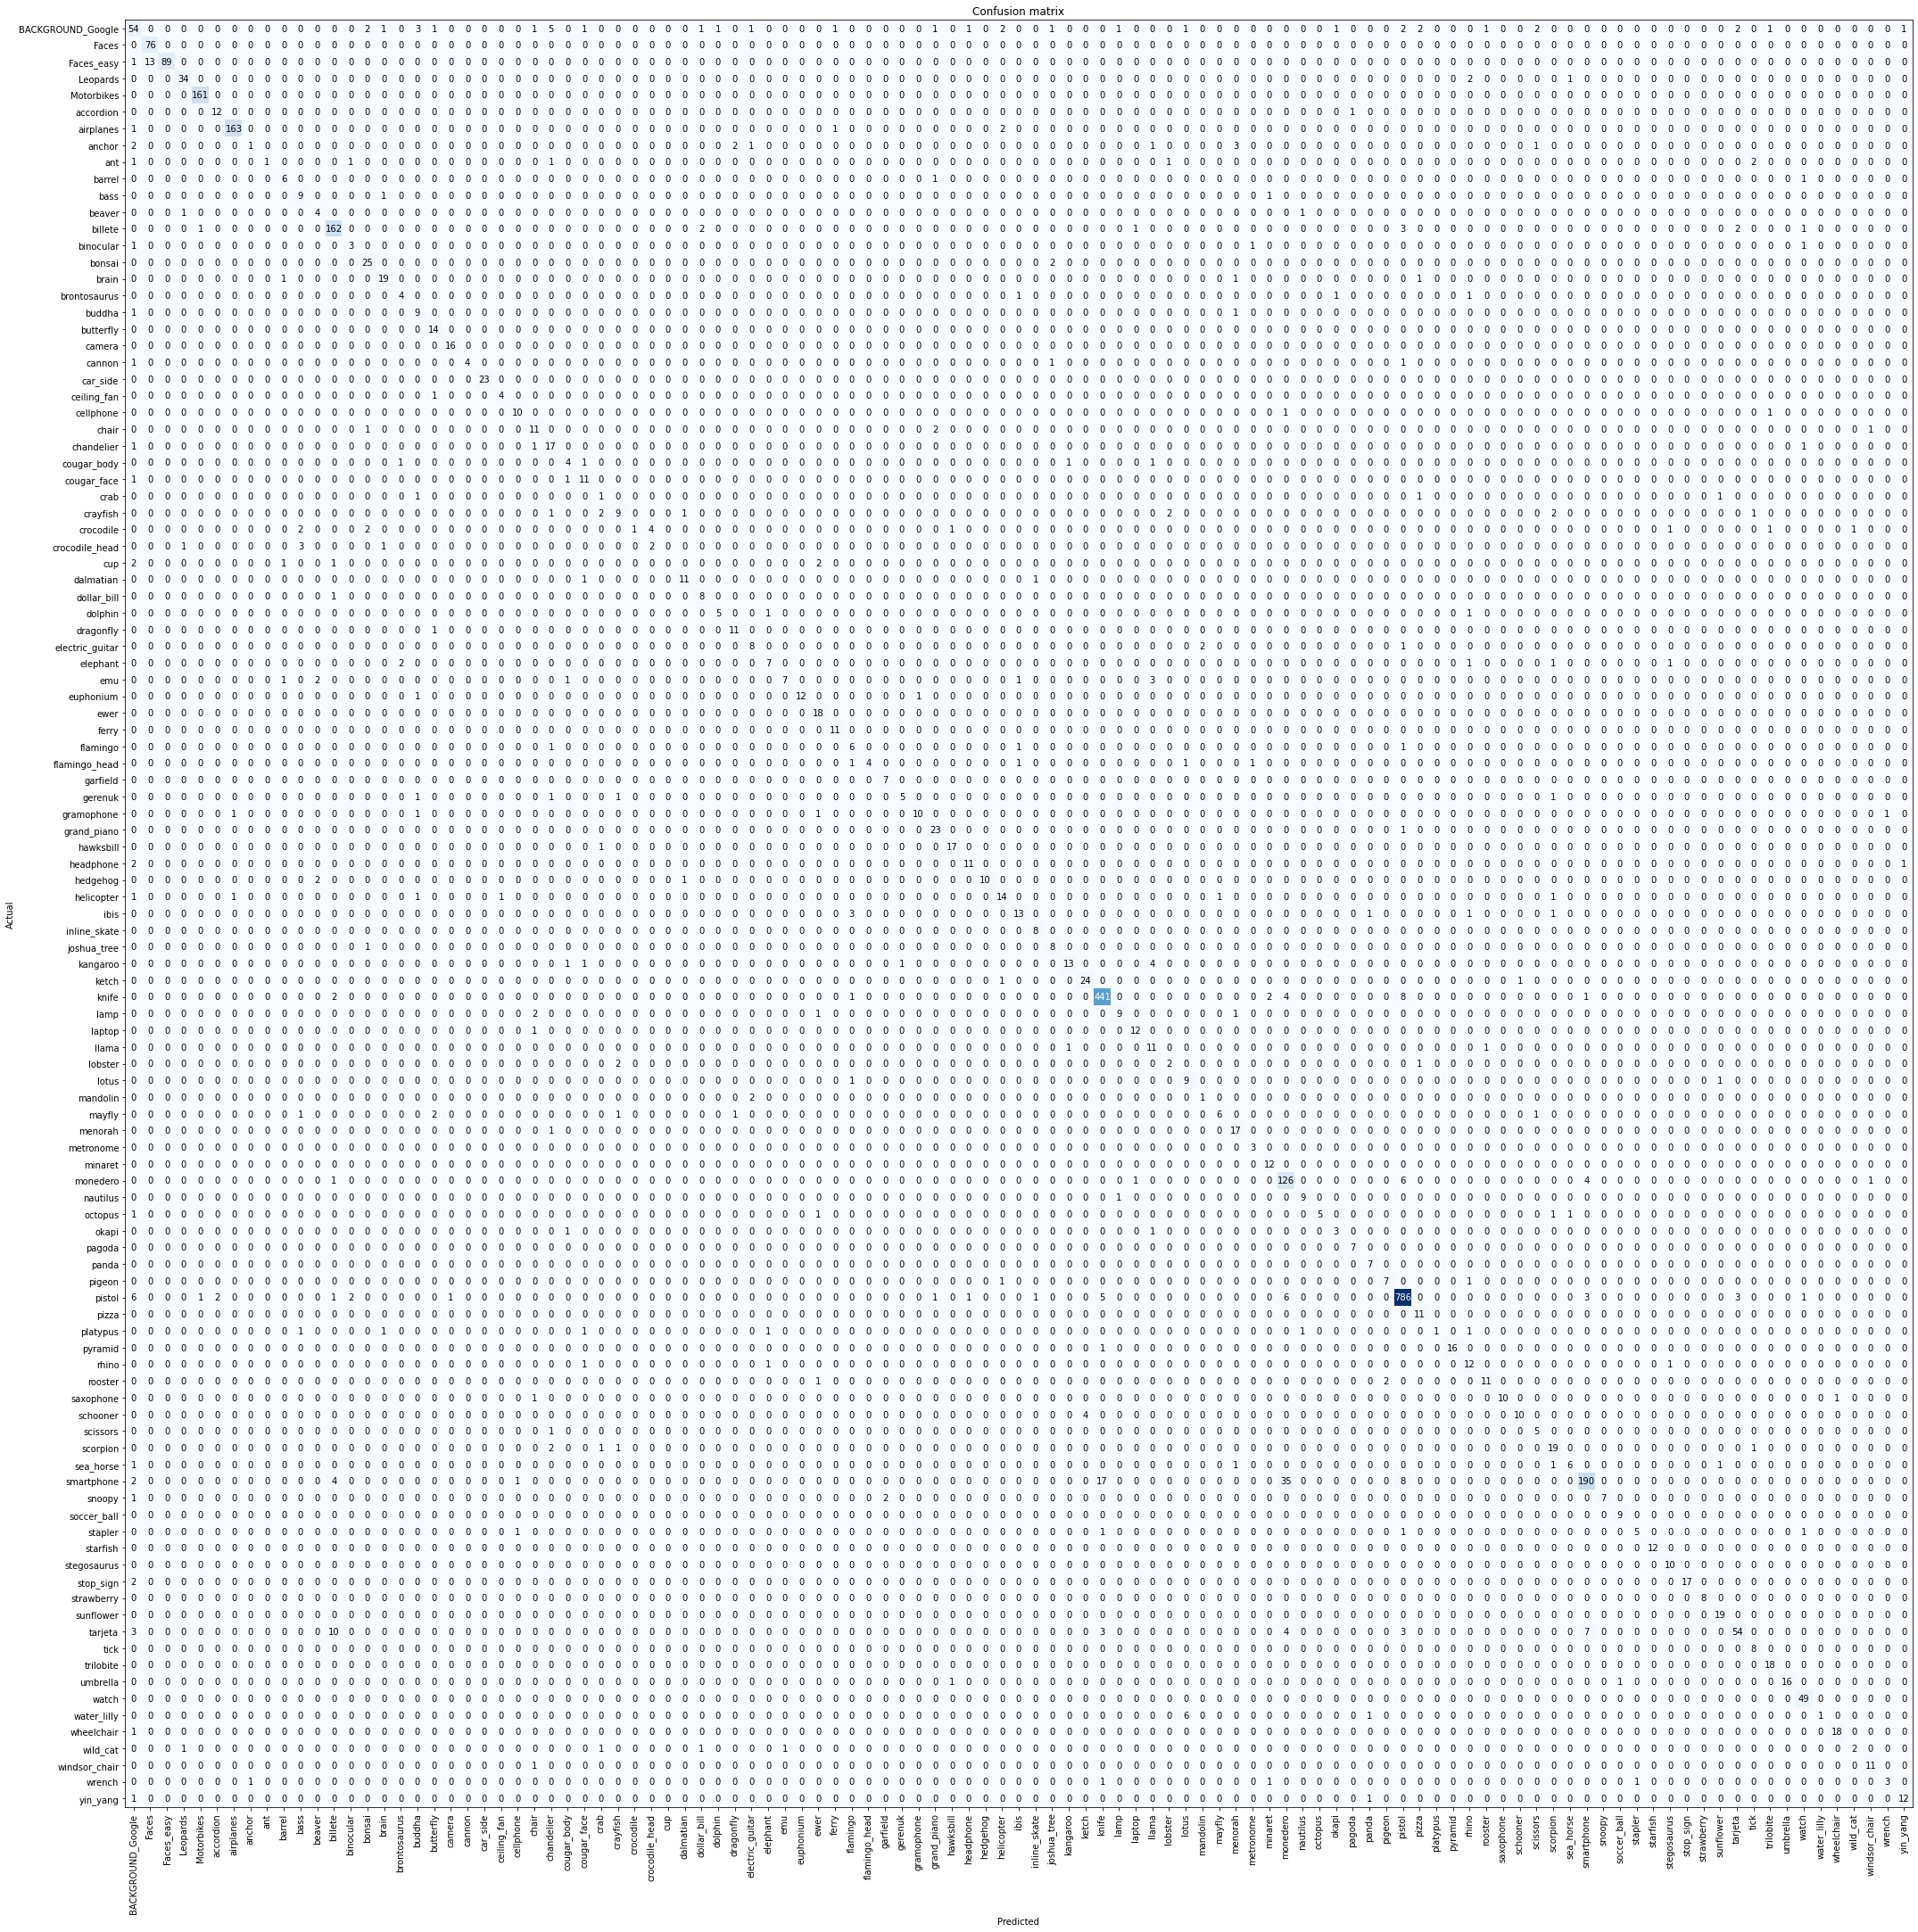

In [12]:
interp.plot_confusion_matrix(figsize=(50,50))

epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,precision_score,recall_score,time
0,1.424714,0.637882,0.820315,0.993317,0.810025,0.836724,0.820315,03:11


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,precision_score,recall_score,time
0,1.131254,0.600119,0.822181,0.994533,0.811494,0.851402,0.822181,03:03


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,precision_score,recall_score,time
0,0.855643,0.431342,0.870168,0.996609,0.866308,0.887048,0.870168,08:26


CPU times: user 25 s, sys: 714 ms, total: 25.7 s
Wall time: 41.7 s


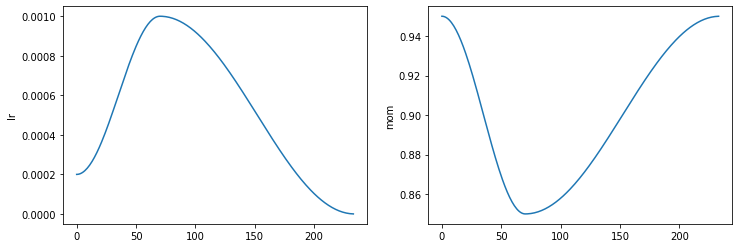

In [18]:
vgg_learner = train_cnn(models.vgg16, 1,2.2e-3)
vgg_learner.recorder.plot_sched()
vgg_learner.export(fname= 'vgg_model.pkl')

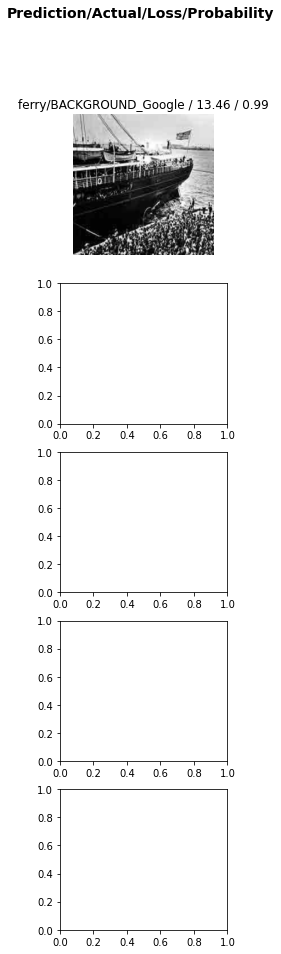

In [19]:
interp = interpretation(vgg_learner)

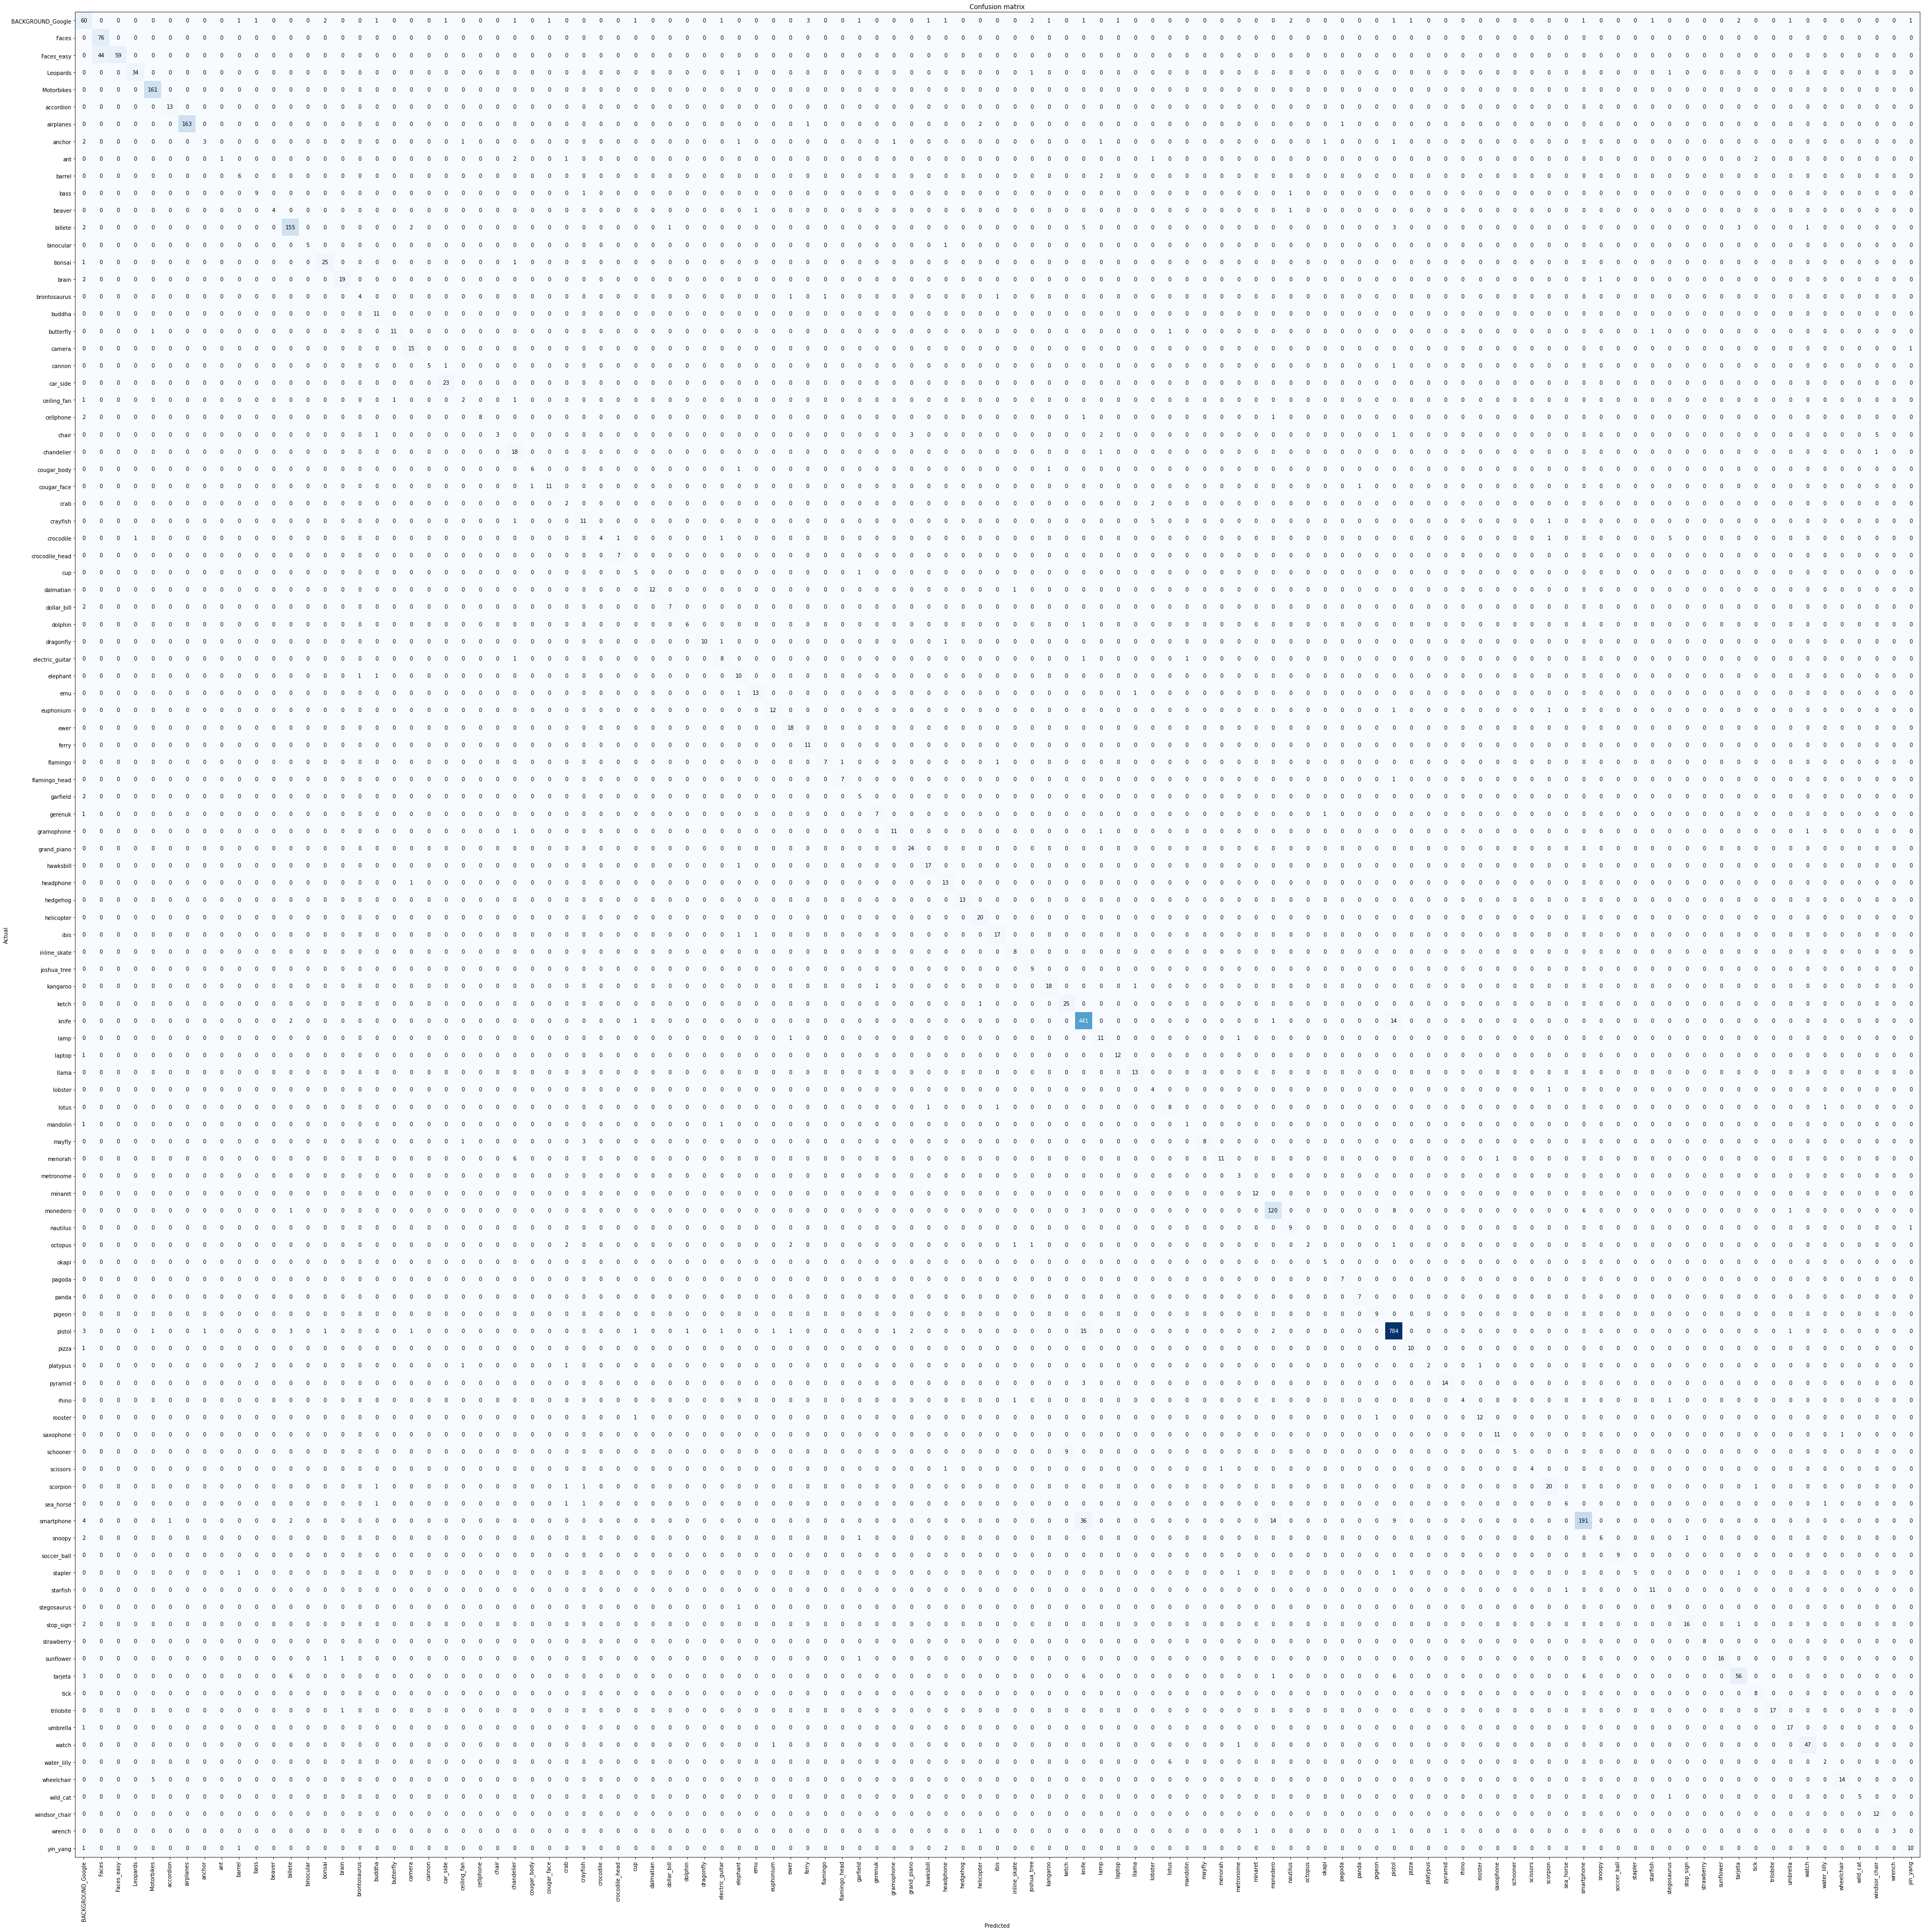

In [20]:
interp.plot_confusion_matrix(figsize=(50,50));

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,precision_score,recall_score,time
0,1.620281,0.934004,0.731538,0.985188,0.718907,0.745681,0.731538,01:52


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,precision_score,recall_score,time
0,1.313364,0.825422,0.753133,0.988378,0.738954,0.773005,0.753132,01:48


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,precision_score,recall_score,time
0,1.114590,0.698387,0.790722,0.991927,0.781717,0.805202,0.790722,01:53


CPU times: user 3.47 s, sys: 564 ms, total: 4.03 s
Wall time: 24.6 s


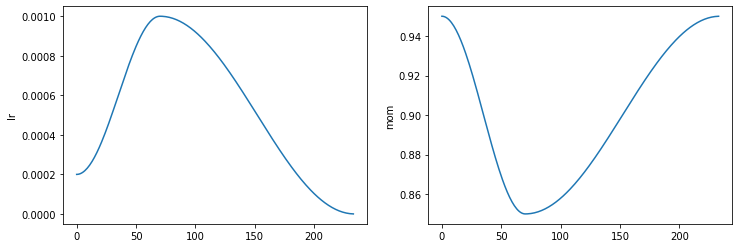

In [21]:
alexnet_learner = train_cnn(models.alexnet,1,2.4e-2)
alexnet_learner.recorder.plot_sched()
alexnet_learner.export(fname='alexnet_model.pkl')

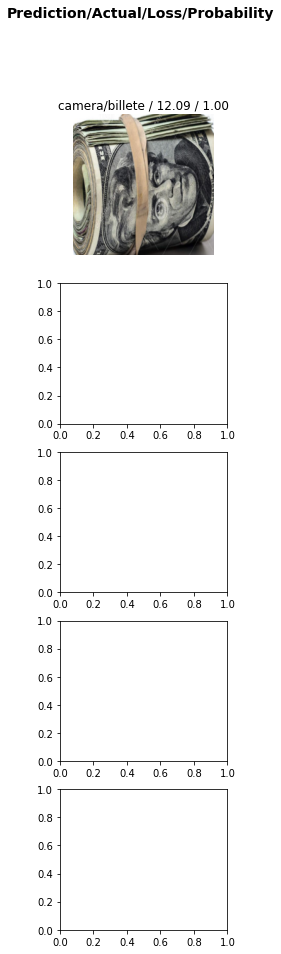

In [24]:
interp = interpretation(alexnet_learner)


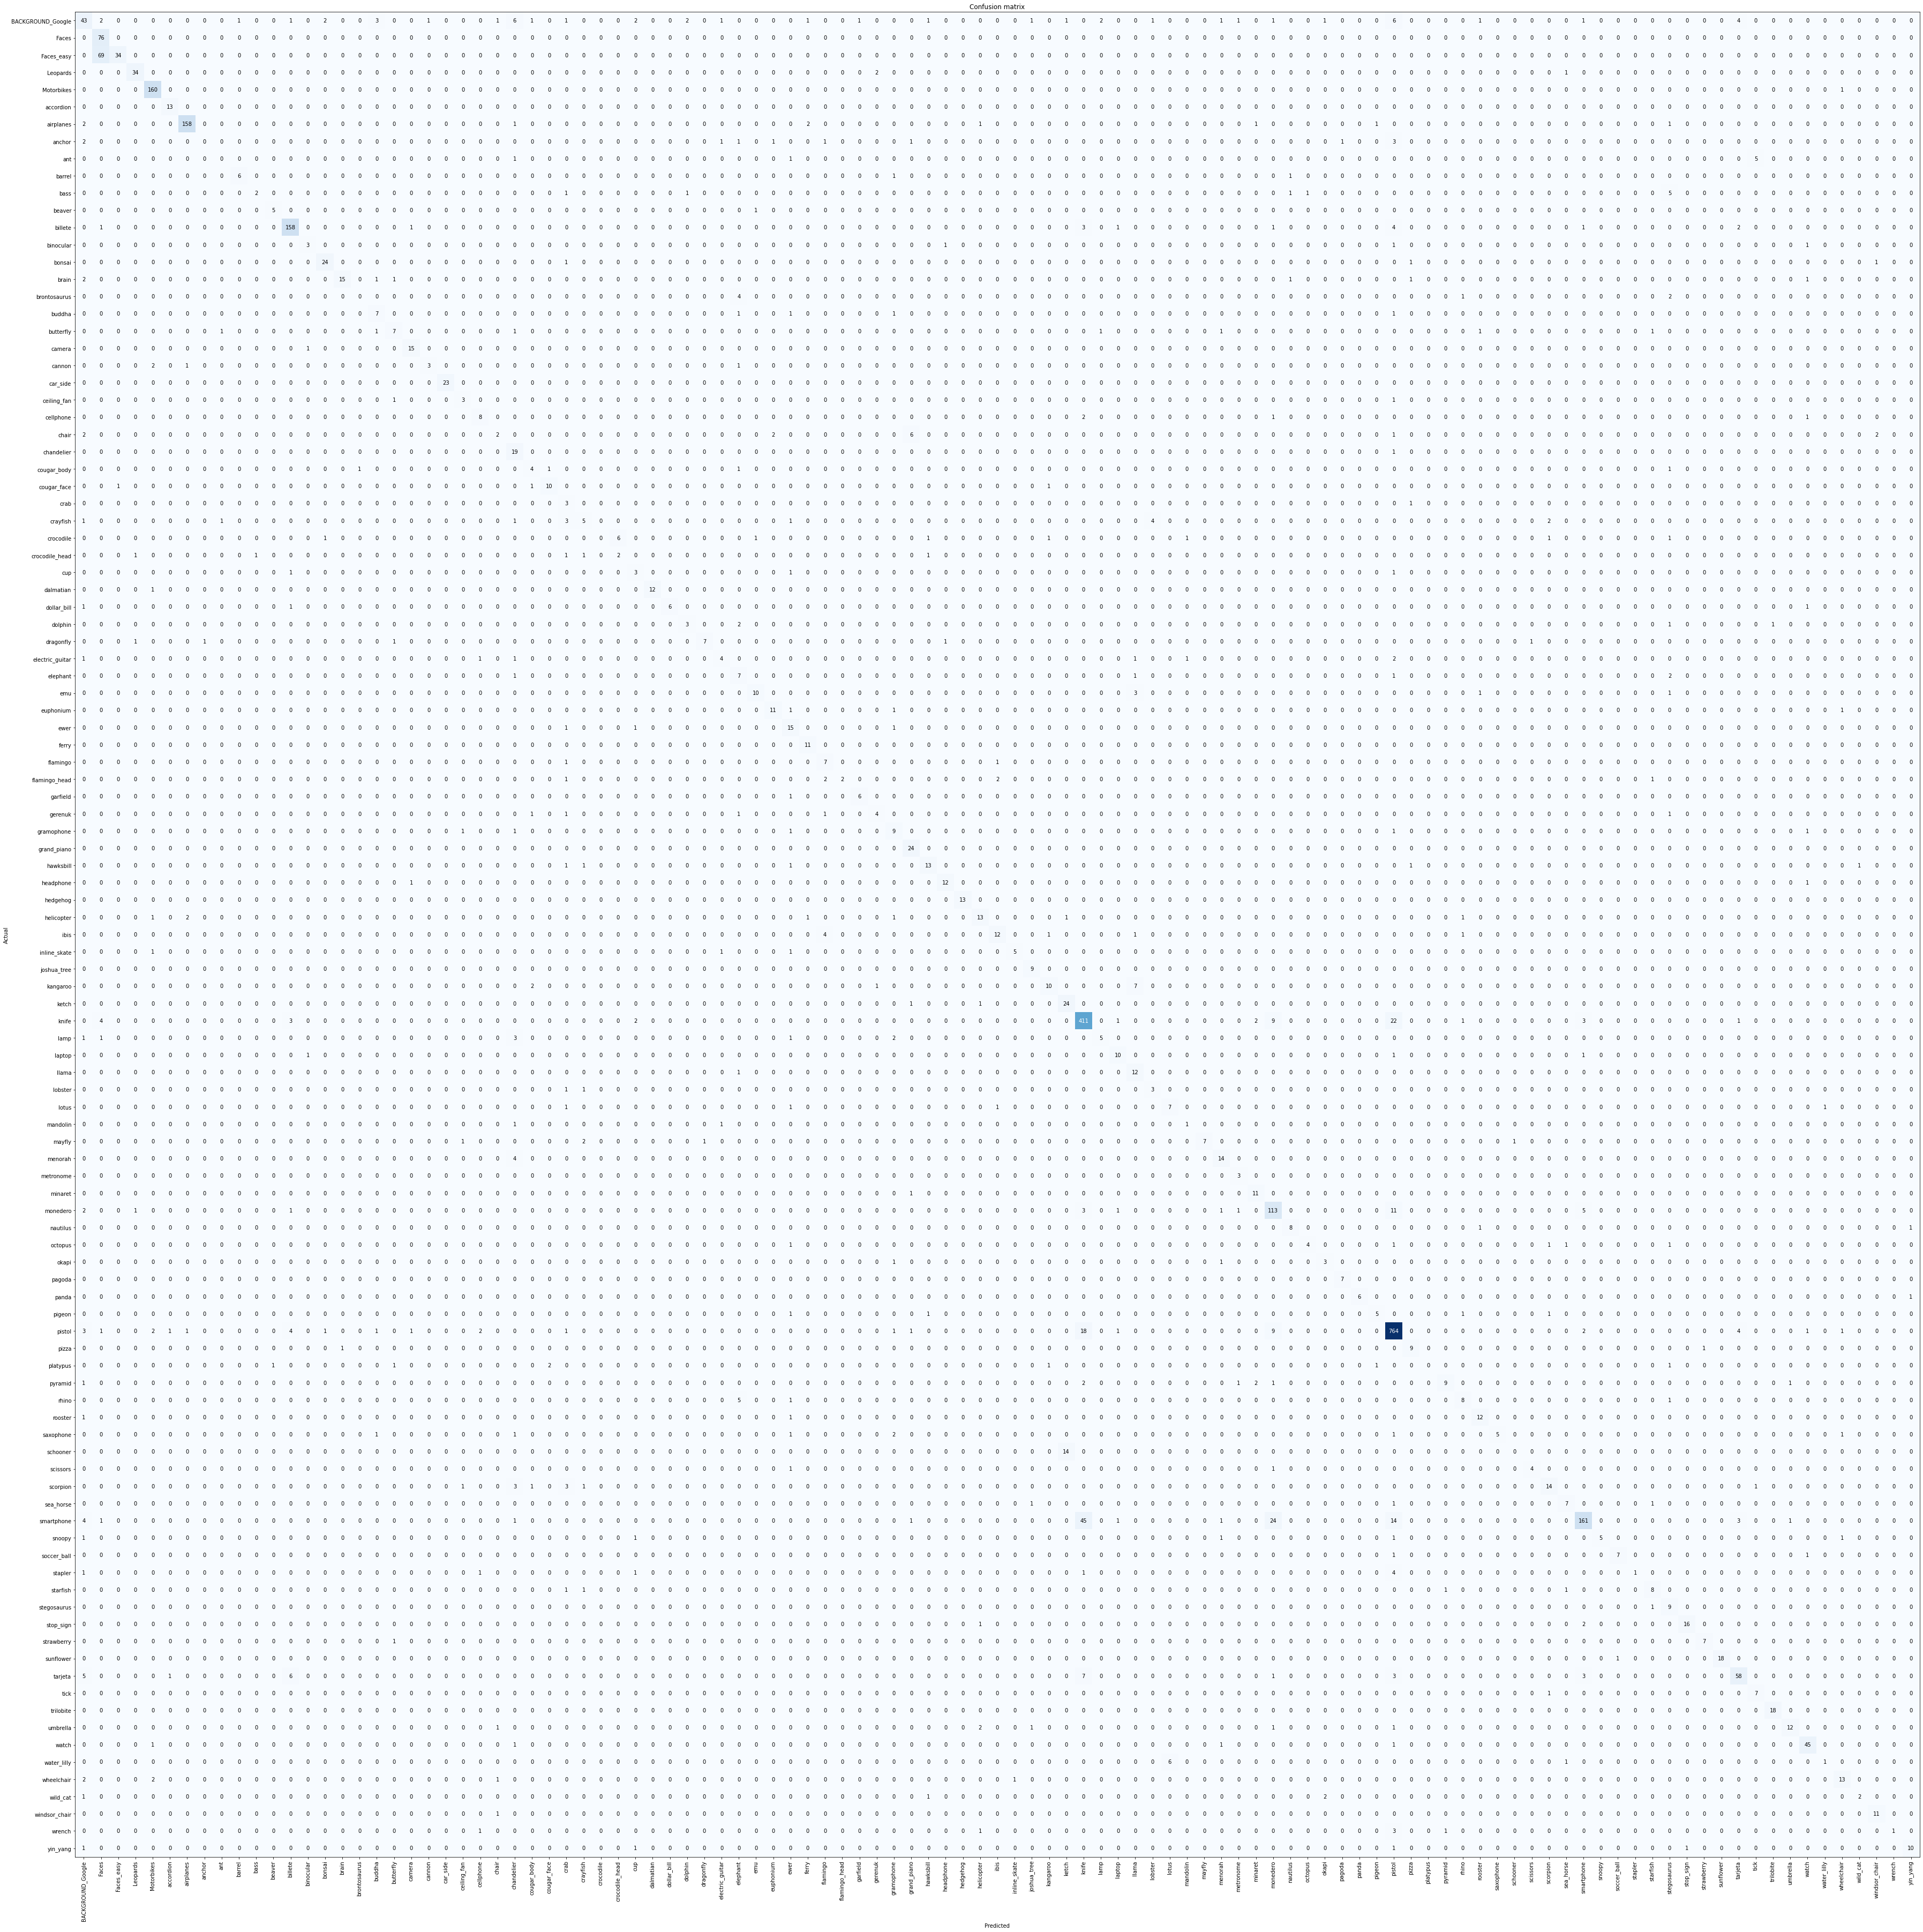

In [25]:
interp.plot_confusion_matrix(figsize=(50,50));